In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import print_function, absolute_import, division

In [3]:
import numpy as np
from wgomoku import (
    GomokuBoard, Move, StochasticMaxSampler, HeuristicGomokuPolicy, 
    ThreatSearch, Heuristics, GomokuTools as gt)

In [4]:
A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U = \
    1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
BLACK=0
WHITE=1
EDGES=2

## A sampler
This class allows to sample from the top n of an array of scores, 
with higher probability for the larger scores. With bias > 1.0,
the sampler has an even higher bias toward the larger scores.


In [5]:
sample = np.random.randint(0, 100, [8,8])/20.0
enumerated = list(np.ndenumerate(sample))
sampler = StochasticMaxSampler(enumerated, 10, bias=5)
sampler.choices

[(0.7501972984156395, (4, 4), 0.24980270158436044, 4.85),
 (0.5003945968312791, (0, 1), 0.24980270158436044, 4.85),
 (0.3058480572240266, (7, 0), 0.19454653960725254, 4.8),
 (0.23427838495147268, (5, 6), 0.07156967227255388, 4.6),
 (0.1627087126789188, (0, 7), 0.07156967227255388, 4.6),
 (0.10697019586888995, (3, 7), 0.055738516810028824, 4.55),
 (0.0731630764966994, (7, 6), 0.03380711937219055, 4.45),
 (0.046834065456248915, (3, 1), 0.026329011040450486, 4.4),
 (0.02050505441579843, (2, 2), 0.026329011040450486, 4.4),
 (0.0, (5, 1), 0.02050505441579843, 4.35)]

In [6]:
print([sampler.draw() for i in range(10)])

[(7, 6), (4, 4), (0, 1), (0, 1), (0, 1), (4, 4), (3, 7), (4, 4), (4, 4), (0, 1)]


## Use a policy to play a bit

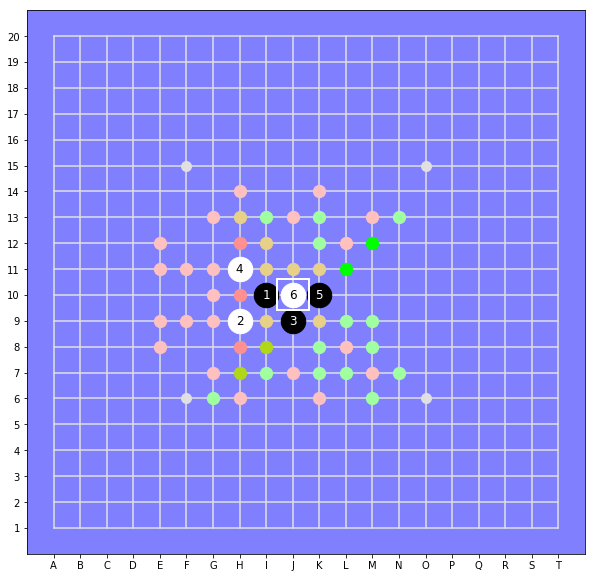

In [7]:
h = Heuristics(kappa=3.0)
board = GomokuBoard(h, N=20, disp_width=10)
p = HeuristicGomokuPolicy(style = 2, bias=.5, topn=5, threat_search=ThreatSearch(5,3))
board.set(I,10).set(H,9).set(J,9).set(H,11).set(K,10).set(J,10)
board.display('current');

CPU times: user 5.77 s, sys: 97 ms, total: 5.87 s
Wall time: 5.87 s
Style: 2: (K, 9)
Value after the move: -40.21966338430434


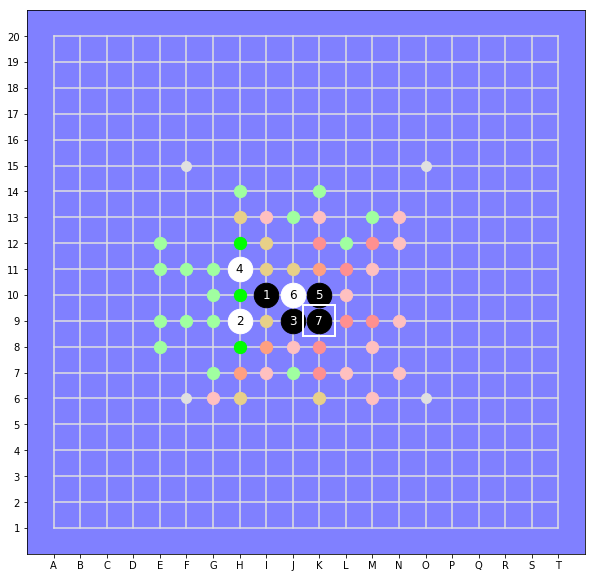

In [8]:
%time move = p.suggest(board)
print(move)
if move.status == 0:
    board.set(move.x, move.y) 
    print("Value after the move: %s" % board.get_value())
else:
    print("GAME OVER!")
board.display('current')

## Self play

Black 7: - Style: 0: (G, 6)
White 8: - Style: 2: (M, 12)
Black 9: - Style: 0: (L, 9)
White 10: - Style: 2: (N, 7)
Black 11: - Style: 0: (I, 12)
White 12: - Defending Win-in-2: (J, 11)
Black 13: - Defending lurking threat sequence: (I, 11)
White 14: - Defending Win-in-2: (I, 9)
Black 15: - Defending Soft-win-in-2: (H, 8)
White 16: - Style: 2: (L, 7)
Black 17: - Style: 0: (I, 6)
White 18: - Defending lurking threat sequence: (I, 8)
Black 19: - Style: 0: (I, 4)
White 20: - Style: 2: (H, 10)
Black 21: - Defending Soft-win-in-2: (K, 7)
White 22: - Defending Soft-win-in-2: (K, 8)
Black 23: - Pursuing winning threat sequence: (I, 13)
White 24: - Defending immediate threat: (I, 14)
Black 25: - Pursuing winning threat sequence: (I, 5)
White 26: - Defending Win-in-2: (I, 3)
Black 27: - Soft-win-in-2: (J, 6)
White 28: - Defending Win-in-2: (H, 4)
Black 29: - Win-in-2: (H, 6)
Black wins.


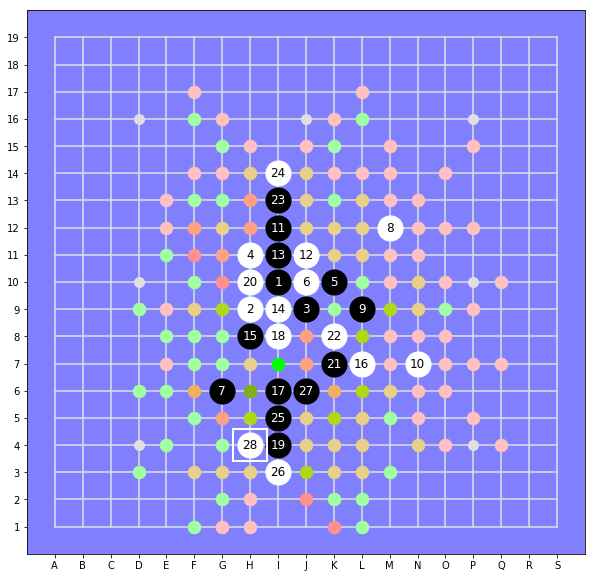

In [9]:
def play_game(options, board, black, white):
    verbose=options['verbose']
    winner = 0
    for _ in range(30):
        move = black.suggest(board)
        if verbose >= 2:
            print("Black %s: - %s" % (len(board.stones)+1, str(move)))
        if move.status != 0:
            winner = move.status
            break
        # Some strange things do happen!
        elif move.x == 0:
            winner = 0
            break
        board.set(move.x, move.y)
        move = white.suggest(board)
        if verbose >= 2:
            print("White %s: - %s" % (len(board.stones)+1, str(move)))
        if move.status != 0:
            winner = -move.status
            break
        board.set(move.x, move.y)
    if verbose >= 1:
        print("Black wins." if winner == 1 else "White wins." if winner == -1 else "Not decided yet." )
    return board, gt.stones_to_string(board.stones), winner


game="i10h9j9h11k10j10"
board = GomokuBoard(h, N=19, disp_width=10, stones=gt.string_to_stones(game))

# Loose (bias=.5), aggressive (style=0), forward-looking (thread_search)
black = HeuristicGomokuPolicy(style = 0, bias=0.5, topn=5, 
                              threat_search=ThreatSearch(5,5))

# Tighter (bias=1.0), defensive (style=2), not as much forward-looking (thread_search)
white = HeuristicGomokuPolicy(style = 2, bias=1.0, topn=5, 
                              threat_search=ThreatSearch(4,4))

board, _, _ = play_game({'verbose': 2}, board, black, white)
board.display('current')

In [15]:
game="i10h9j9h11k10j10"
board = GomokuBoard(h, N=19, disp_width=10, stones=gt.string_to_stones(game))

# Tight (bias=2.0), aggressive (style=0), forward-looking (thread_search)
black = HeuristicGomokuPolicy(style = 0, bias=0.5, topn=5, 
                              threat_search=ThreatSearch(3,3))

# Very tight (bias=10.0), defensive (style=2), not as much forward-looking (thread_search)
white = HeuristicGomokuPolicy(style = 2, bias=2.0, topn=5, 
                              threat_search=ThreatSearch(3,3))

board, _, _ = play_game({'verbose': 2}, board, black, white)
board.display('current')

Black 7: - Style: 0: (G, 6)
White 8: - Style: 2: (L, 11)
Black 9: - Style: 0: (L, 9)
White 10: - Style: 2: (I, 8)


KeyboardInterrupt: 

In [ ]:
game="i10h9j9h11k10j10"
results=[]
for _ in range(1):
    board = GomokuBoard(h, N=19, disp_width=10, stones=gt.string_to_stones(game))
    black = HeuristicGomokuPolicy(style = 0, bias=0.5, topn=5, threat_search=ThreatSearch(3,3))
    white = HeuristicGomokuPolicy(style = 2, bias=1.0, topn=5, threat_search=ThreatSearch(2,3))
    board, record, status = play_game({'verbose': 1}, board, black, white)
    results.append([record, status])

In [17]:
import pandas as pd

In [18]:
df = pd.DataFrame(results)
df.columns=['game', 'winner']
df.to_csv("self_play_games-6.csv", index=None)

In [19]:
df.head()

,game,winner
0,i10h9j9h11k10j10g6m12l9n7m9k9h12p9i12j11i13i11...,1


In [20]:
df1 = pd.read_csv("self_play_games-1.csv")
df2 = pd.read_csv("self_play_games-2.csv")
df3 = pd.read_csv("self_play_games-3.csv")
df4 = pd.read_csv("self_play_games-4.csv")
df5 = pd.read_csv("self_play_games-5.csv")
df6 = pd.read_csv("self_play_games-6.csv")

In [21]:
dfm = df1.append(df2).append(df3).append(df4).append(df5).append(df6)
dfm.count()

game      500
winner    500
dtype: int64

In [22]:
dfm[dfm['winner']==-1].count()

game      127
winner    127
dtype: int64